# in some plots we are having 1 SOS with no EOS.

Why nullify function did not work?

In [2]:
# import warnings
# warnings.filterwarnings("ignore")

import csv
import numpy as np
import pandas as pd
# import geopandas as gpd
from IPython.display import Image
# from shapely.geometry import Point, Polygon
from math import factorial
import scipy
import scipy.signal
import os, os.path

from datetime import date
import datetime
import time

from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.linear_model import LinearRegression
from patsy import cr

# from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sb

import sys

In [3]:
sys.path.append('/Users/hn/Documents/00_GitHub/Ag/remote_sensing/python/')

import remote_sensing_core as rc
import remote_sensing_plot_core as rcp

data_dir = "/Users/hn/Documents/01_research_data/remote_sensing/test_Aeolus_data/"


In [4]:
eleven_colors = ["gray", "lightcoral", "red", "peru",
                 "darkorange", "gold", "olive", "green",
                 "blue", "violet", "deepskyblue"]

indeks = "EVI"
given_county = "Grant"
SF_year = 2017
sos_thresh = 0.5
eos_thresh = 0.5
minFinderDetla = 0.4

f_name = "01_Regular_filledGap_Grant_SF_2017_EVI.csv"
a_df = pd.read_csv(data_dir + f_name, low_memory=False)


if 'Date' in a_df.columns:
    if type(a_df.Date.iloc[0]) == str:
        a_df['Date'] = pd.to_datetime(a_df.Date.values).values

a_df = a_df[a_df['county'] == given_county.replace("_", " ")] # Filter Grant
# a_df = rc.filter_out_NASS(a_df) # Toss NASS
# a_df = rc.filter_by_lastSurvey(a_df, year = SF_year) # filter by last survey date
a_df['SF_year'] = SF_year

if not('DataSrc' in a_df.columns):
    print ("Data source is being set to NA")
    a_df['DataSrc'] = "NA"

if not('CovrCrp' in a_df.columns):
    print ("CovrCrp is being set to NA")
    a_df['CovrCrp'] = "NA"
    
print (a_df.shape)

CovrCrp is being set to NA
(902955, 23)


In [5]:
print (a_df.shape)

a_df = rc.initial_clean(df = a_df, column_to_be_cleaned = indeks)

an_EE_TS = a_df.copy()

print (an_EE_TS.shape)

### List of unique polygons
polygon_list = np.sort(an_EE_TS['ID'].unique())
print ("_____________________________________")
print("len(polygon_list)")
print (len(polygon_list))
print ("_____________________________________")

counter = 0


(902955, 23)
(902955, 23)
_____________________________________
len(polygon_list)
17705
_____________________________________


In [6]:
a_poly = "100106_WSDA_SF_2017"
          
a_poly in (polygon_list)

True

In [7]:
if (counter%10 == 0):
        print ("_____________________________________")
        print ("counter: " + str(counter))
        print (a_poly)
        
curr_field = an_EE_TS[an_EE_TS['ID']==a_poly].copy()

#
#  filter just one year to have a clean SOS EOS stuff
#
curr_field = curr_field[curr_field.image_year == SF_year]

################################################################
# Sort by DoY (sanitary check)
curr_field.sort_values(by=['image_year', 'doy'], inplace=True)



_____________________________________
counter: 0
100106_WSDA_SF_2017


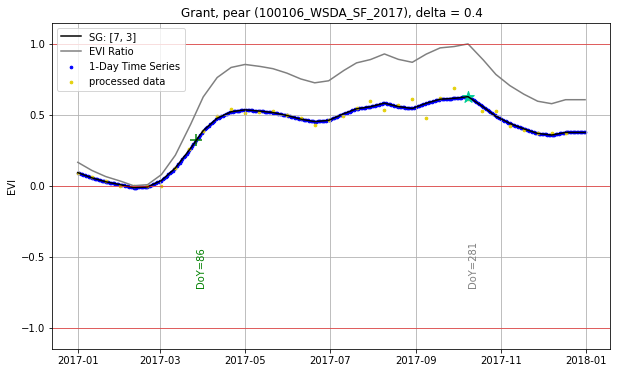

In [9]:
fig, axs = plt.subplots(1, 1, figsize=(10,6),
                        sharex='col', sharey='row',
                        gridspec_kw={'hspace': 0.1, 'wspace': .1});
(ax1) = axs;
ax1.grid(True); # ax2.grid(True);


dataAB = curr_field
idx=indeks
SG_params=[7, 3]
SFYr = SF_year
ax=ax1
deltA= minFinderDetla
onset_cut = sos_thresh
offset_cut = eos_thresh

rcp.SG_1yr_panels_clean_sciPy_My_Peaks_SOS_fineGranularity_1Year(dataAB = curr_field, 
                                                                 idx=indeks, 
                                                                 SG_params=SG_params, 
                                                                 SFYr = SF_year, ax=ax1, deltA= minFinderDetla,
                                                                 onset_cut = sos_thresh, 
                                                                 offset_cut = eos_thresh);

fig_name = "/Users/hn/Documents/00_GitHub/Ag/remote_sensing/" + \
           "python/Local_Jupyter_NoteBooks/scratches_to_experiment/1SOS.png"

# plt.savefig(fname = fig_name, dpi=400, bbox_inches='tight')

In [8]:
dataAB = curr_field
idx = indeks
SG_params=[5, 1]
SFYr = SF_year
ax = ax1
deltA = minFinderDetla
onset_cut = sos_thresh
offset_cut = eos_thresh

In [9]:
crr_fld = dataAB.copy()
if (not("human_system_start_time" in list(crr_fld.columns))):
    crr_fld = rc.add_human_start_time(crr_fld)

eleven_colors = ["gray", "lightcoral", "red", "peru",
                 "darkorange", "gold", "olive", "green",
                 "blue", "violet", "deepskyblue"]

plant = crr_fld['CropTyp'].unique()[0]
# Take care of names, replace "/" and "," and " " by "_"
plant = plant.replace("/", "_")
plant = plant.replace(",", "_")
plant = plant.replace(" ", "_")
plant = plant.replace("__", "_")

county = crr_fld['county'].unique()[0]
ID = crr_fld['ID'].unique()[0]

y = crr_fld[idx].copy()

#############################################
###
###             Smoothen
###
#############################################
# differences are minor, but lets keep using Pythons function
# my_savitzky_pred = rc.savitzky_golay(y, window_size=Sav_win_size, order=sav_order)
window_len = SG_params[0]
poly_order = SG_params[1]

SG_pred = scipy.signal.savgol_filter(y, window_length= window_len, polyorder=poly_order)

# SG might violate the boundaries. clip them:
SG_pred[SG_pred > 1 ] = 1
SG_pred[SG_pred < -1 ] = -1

crr_fld[idx] = SG_pred

#############################################
###
###             fine granularity table
###
#############################################
# create the full calenadr to make better estimation of SOS and EOS.
fine_granular_table = rc.create_calendar_table(SF_year = SFYr)
fine_granular_table = pd.merge(fine_granular_table, crr_fld, on=['Date', 'SF_year', 'doy'], how='left')

###### We need to fill the NAs that are created because they were not created in fine_granular_table
fine_granular_table["image_year"] = crr_fld["image_year"].unique()[0]
fine_granular_table["ID"]     = crr_fld["ID"].unique()[0]
fine_granular_table["Acres"]  = crr_fld["Acres"].unique()[0]
fine_granular_table["county"] = crr_fld["county"].unique()[0]

fine_granular_table["CropGrp"] = crr_fld["CropGrp"].unique()[0]
fine_granular_table["CropTyp"] = crr_fld["CropTyp"].unique()[0]
fine_granular_table["DataSrc"] = crr_fld["DataSrc"].unique()[0]
fine_granular_table["ExctAcr"] = crr_fld["ExctAcr"].unique()[0]

fine_granular_table["IntlSrD"] = crr_fld["IntlSrD"].unique()[0]
fine_granular_table["Irrigtn"] = crr_fld["Irrigtn"].unique()[0]

fine_granular_table["LstSrvD"] = crr_fld["LstSrvD"].unique()[0]
fine_granular_table["Notes"]   = crr_fld["Notes"].unique()[0]
fine_granular_table["RtCrpTy"] = crr_fld["RtCrpTy"].unique()[0]
fine_granular_table["Shap_Ar"] = crr_fld["Shap_Ar"].unique()[0]
fine_granular_table["Shp_Lng"] = crr_fld["Shp_Lng"].unique()[0]
fine_granular_table["TRS"] = crr_fld["TRS"].unique()[0]

fine_granular_table = rc.add_human_start_time_by_YearDoY(fine_granular_table)

# replace NAs with -1.5. Because, that is what the function fill_theGap_linearLine()
# uses as indicator for missing values
fine_granular_table.fillna(value={idx:-1.5}, inplace=True)

fine_granular_table = rc.fill_theGap_linearLine(regular_TS = fine_granular_table, 
                                                V_idx=idx, 
                                                SF_year=SFYr)

# update SG_pred so that we do not have to update too many other stuff.
SG_pred = fine_granular_table[idx].values.copy()
crr_fld = fine_granular_table
y = fine_granular_table[idx].copy()

In [10]:
#############################################
###
###   Form a data table of X and Y values
###
#############################################

if len(fine_granular_table['image_year'].unique()) == 2:
    X = rc.extract_XValues_of_2Yrs_TS(fine_granular_table, SF_yr = SFYr)
elif len(fine_granular_table['image_year'].unique()) == 1:
    X = fine_granular_table['doy']

d = {'DoY': X, 'Date': pd.to_datetime(fine_granular_table.human_system_start_time.values).values}
date_df = pd.DataFrame(data=d)

min_val_for_being_peak = 0.5


In [11]:
crr_fld [idx] = SG_pred
crr_fld = rc.addToDF_SOS_EOS_White(pd_TS = crr_fld, 
                                   VegIdx = idx, 
                                   onset_thresh = onset_cut, 
                                   offset_thresh = offset_cut)

In [ ]:
###
### Null_SOS_EOS_by_DoYDiff(pd_TS, min_season_length=40)
###
pd_TS = crr_fld.copy()
min_season_length=40

In [ ]:
pd_TS_DoYDiff = pd_TS.copy()

# find indexes of SOS and EOS
SOS_indexes = pd_TS_DoYDiff.index[pd_TS_DoYDiff['SOS'] != 0].tolist()
EOS_indexes = pd_TS_DoYDiff.index[pd_TS_DoYDiff['EOS'] != 0].tolist()

In [ ]:
SOS_indexes

In [ ]:
EOS_indexes